In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import os
from skimage.io import imread_collection
from skimage.color import rgb2gray
import pandas as pd
%matplotlib inline
from skimage.io import imread
import glob
from PIL import Image
import sklearn
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.layers import Activation

print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

TensorFlow Version: 2.6.0
Num GPUs Available:  1


In [2]:
csv_path = "D:\\Deep Learning Project\\final\\CXRNormalClassifer\\correctLabelDataVersion\\final\\all_findings_expert_labels_test_labels.csv"
df = pd.read_csv(csv_path)
image_diagnosis_pairs = list(zip(df["Image ID"], df["Abnormal"]))

TARGET_SIZE = (512, 512)

def load_dataset_from_directory(dir_path, image_diagnosis_pairs):
    image_paths = glob.glob(os.path.join(dir_path, '*.png'))
    
    paired_data_list = []
    for row in image_diagnosis_pairs:
        file_name, diagnosis = row

        for image_path in image_paths:
            image_name = os.path.basename(image_path)
            if file_name == image_name:
                image = Image.open(image_path).convert('RGB')
                image = image.resize(TARGET_SIZE)  
                image_array = np.array(image, dtype=np.float32)
                paired_data_list.append((image_array, diagnosis, image_name))  
                break

    image_list = [item[0] for item in paired_data_list]
    diagnosis_list = [item[1] for item in paired_data_list]
    image_name_list = [item[2] for item in paired_data_list]  
    binary_diagnosis_list = [0 if diagnosis == "NO" else 1 for diagnosis in diagnosis_list]
    
    image_dataset = tf.data.Dataset.from_tensor_slices(image_list)
    binary_diagnosis_dataset = tf.data.Dataset.from_tensor_slices(binary_diagnosis_list)
    image_name_dataset = tf.data.Dataset.from_tensor_slices(image_name_list) 
    
    return tf.data.Dataset.zip((image_dataset, binary_diagnosis_dataset, image_name_dataset))

directories = [
    'D:\\Deep Learning Project\\final\\CXRNormalClassifer\\correctLabelDataVersion\\final\\train\\trainset1',
    'D:\\Deep Learning Project\\final\\CXRNormalClassifer\\correctLabelDataVersion\\final\\train\\trainset2',
    'D:\\Deep Learning Project\\final\\CXRNormalClassifer\\correctLabelDataVersion\\final\\train\\trainset3',
    'D:\\Deep Learning Project\\final\\CXRNormalClassifer\\correctLabelDataVersion\\final\\train\\trainset4',
    'D:\\Deep Learning Project\\final\\CXRNormalClassifer\\correctLabelDataVersion\\final\\train\\trainset5',
    'D:\\Deep Learning Project\\final\\CXRNormalClassifer\\correctLabelDataVersion\\final\\train\\trainset6',
    'D:\\Deep Learning Project\\final\\CXRNormalClassifer\\correctLabelDataVersion\\final\\train\\trainset7',
    'D:\\Deep Learning Project\\final\\CXRNormalClassifer\\correctLabelDataVersion\\final\\train\\trainset8',
    'D:\\Deep Learning Project\\final\\CXRNormalClassifer\\correctLabelDataVersion\\final\\train\\trainset9',
    'D:\\Deep Learning Project\\final\\CXRNormalClassifer\\correctLabelDataVersion\\final\\train\\trainset10',
    'D:\\Deep Learning Project\\final\\CXRNormalClassifer\\correctLabelDataVersion\\final\\train\\trainset11',
    'D:\\Deep Learning Project\\final\\CXRNormalClassifer\\correctLabelDataVersion\\final\\train\\trainset12',
    'D:\\Deep Learning Project\\final\\CXRNormalClassifer\\correctLabelDataVersion\\final\\train\\trainset13augment'
]

datasets = {}
for i, dir_path in enumerate(directories, start=1):
    dataset = load_dataset_from_directory(dir_path, image_diagnosis_pairs)
    datasets[f"dataset_{i}"] = dataset
    print(f"Length of dataset_{i}:", len(dataset))
    tf.keras.backend.clear_session()

Length of dataset_1: 318
Length of dataset_2: 185
Length of dataset_3: 165
Length of dataset_4: 149
Length of dataset_5: 284
Length of dataset_6: 208
Length of dataset_7: 108
Length of dataset_8: 252
Length of dataset_9: 196
Length of dataset_10: 197
Length of dataset_11: 170
Length of dataset_12: 237
Length of dataset_13: 40


Image name: tf.Tensor(b'00009437_005.png', shape=(), dtype=string)
Image shape: (512, 512, 3)
Diagnosis: tf.Tensor(0, shape=(), dtype=int32)


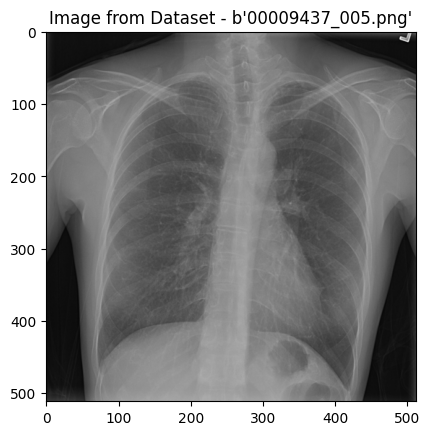

Text(0.5, 1.0, 'Verification Image')

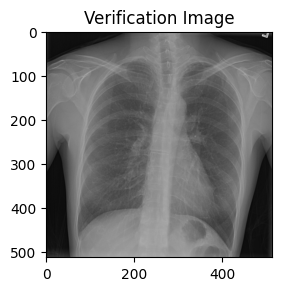

In [3]:
################## V E R I F I C A T I O N # T H E # R I G H T # P I X E L S # G O T # R U N ###################
################################### O P T I O N A L ### R U N ##################################################
################################### B L O C K # 1 ##############################################################

third_dataset = datasets["dataset_5"]

for image, diagnosis, image_name in third_dataset.take(1):
    print("Image name:", image_name)
    print("Image shape:", image.shape)
    print("Diagnosis:", diagnosis)
    
    plt.figure()
    plt.imshow(image.numpy().astype('uint8'))  
    plt.title(f"Image from Dataset - {image_name}")

plt.show()

################## V E R I F I C A T I O N # T H E # R I G H T # P I X E L S # G O T # R U N ###################
################################### O P T I O N A L ### R U N ##################################################
################################### B L O C K # 2 ##############################################################

verification = Image.open("D:\\Deep Learning Project\\final\\CXRNormalClassifer\\correctLabelDataVersion\\final\\train\\trainset5\\00009437_005.png").convert('RGB').resize(TARGET_SIZE)
verification_array = np.array(verification, dtype=np.float32)
plt.subplot(1, 2, 1)
plt.imshow(verification_array.astype('uint8'))  
plt.title("Verification Image")

In [4]:
concatenated_dataset = datasets["dataset_1"]

for i in range(2, len(datasets) + 1):
    concatenated_dataset = concatenated_dataset.concatenate(datasets[f"dataset_{i}"])

print(len(concatenated_dataset))


2509


In [5]:
dataset_shuffled = concatenated_dataset.shuffle(buffer_size=100)
print(len(dataset_shuffled))

dataset_batched = dataset_shuffled.batch(64)

for images, labels, image_name_dataset in dataset_batched.take(30):
    print("Labels: ", labels.numpy())

################## V E R I F I C A T I O N # T H E # R I G H T # P I X E L S # G O T # R U N ###################
################################### O P T I O N A L ### R U N ##################################################

#for image_array, diagnosis, image_name in dataset_batched.take(1):
#    for i in range(image_array.shape[0]):
#        current_image = image_array[i]
#        current_image_name = image_name[i].numpy().decode('utf-8')  # Convert image name to string
#        current_diagnosis = diagnosis[i].numpy()

#        print("Image name:", current_image_name)
#        print("Image shape:", current_image.shape)
#        print("Diagnosis:", current_diagnosis)

#        plt.figure()
#        plt.imshow(current_image.numpy().astype('uint8'))  # Convert pixel values back to uint8
#        plt.title(f"Image from Dataset - {current_image_name}")

#plt.show()

2509
Labels:  [1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1]
Labels:  [1 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 0 0
 1 1 0 1 1 1 1 1 0 1 0 1 0 0 1 0 1 0 0 1 1 1 0 0 0 1 1]
Labels:  [0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 1]
Labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1 1 1 0]
Labels:  [1 0 0 1 0 0 0 1 0 0 1 1 1 0 1 0 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 1
 0 1 0 0 0 0 1 1 1 1 1 1 1 0 1 0 0 0 1 1 0 0 0 1 0 0 0]
Labels:  [1 1 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 1 1 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 1 1 0 0 0 1]
Labels:  [0 1 0 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 1
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 1]
Labels:  [1 0 0

In [6]:
def remove_image_name(image_dataset, labels, image_name_dataset):
    return (image_dataset, labels)

dataset_batched_withoutnames = dataset_batched.map(remove_image_name)

for images, labels in dataset_batched_withoutnames.take(1):
    print("Shape of the first image in the batch:", images[0].shape)
    print("Shape of the first label in the batch:", labels[0].shape)

Shape of the first image in the batch: (512, 512, 3)
Shape of the first label in the batch: ()


In [8]:
from tensorflow.keras.applications import ResNet50, ResNet101, ResNet152, InceptionResNetV2, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Activation, BatchNormalization
from tensorflow.keras import mixed_precision, layers, models
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam, RMSprop

mixed_precision.set_global_policy('mixed_float16')

base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

for layer in base_model.layers:
    layer.trainable = False

drop_rate = 0.20

conv1 = layers.Conv2D(32, (3, 3), activation='selu')(base_model.output)
conv2 = layers.Conv2D(32, (1, 1), activation='selu')(conv1)
conv3 = layers.Conv2D(32, (1, 1), activation='selu')(conv2)

flatten = layers.Flatten()(conv3)

dense1 = layers.Dense(64, activation='relu')(flatten)
drop1 = layers.Dropout(drop_rate)(dense1)

dense2 = layers.Dense(64, activation='relu')(drop1)
dense3 = layers.Dense(64, activation='relu')(dense2)
dense4 = layers.Dense(64, activation='relu')(dense3)
dense5 = layers.Dense(64, activation='relu')(dense4)

drop2 = layers.Dropout(drop_rate)(dense5)

output_layer = layers.Dense(1, activation='sigmoid')(drop2)

model = Model(inputs=base_model.input, outputs=output_layer)

initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=50,  
    decay_rate=0.9,    
    staircase=False)

optimizer = Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC(name='auc')]
)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
history = model.fit(dataset_batched_withoutnames, epochs=30)

In [ ]:
########################################## T E S T -- C O D E -- B L O C K ##########################################

import cv2
import numpy as np
import tensorflow as tf

test_directory = ['D:\\Deep Learning Project\\final\\CXRNormalClassifer\\correctLabelDataVersion\\final\\test']

csv_path = "D:\\Deep Learning Project\\final\\CXRNormalClassifer\\correctLabelDataVersion\\final\\all_findings_expert_labels_test_labels.csv"
df_test = pd.read_csv(csv_path)

image_diagnosis_pairs_test = list(zip(df_test["Image ID"], df_test["Abnormal"]))

for i in range(25):  
    print(image_diagnosis_pairs_test[i])

paired_data_list_test = []

for dir_path_test in test_directory:
    image_paths_test = glob.glob(os.path.join(dir_path_test, '*.png'))

    for row in image_diagnosis_pairs_test:
        file_name_test, diagnosis_test = row

        for image_path_test in image_paths_test:
            image_name_test = os.path.basename(image_path_test)
            if file_name_test == image_name_test:
                image_test = Image.open(image_path_test).convert("RGB")  # Convert to grayscale
                image_test = image_test.resize((512, 512))

                image_array_test = np.array(image_test, dtype=np.float32)
                
                paired_data_list_test.append((image_array_test, diagnosis_test))
                break

image_list_test = [item[0] for item in paired_data_list_test]
diagnosis_list_test = [item[1] for item in paired_data_list_test]
binary_diagnosis_list_test = [0 if diagnosis == "NO" else 1 for diagnosis in diagnosis_list_test]

image_testset = tf.data.Dataset.from_tensor_slices(image_list_test)
binary_diagnosis_testset = tf.data.Dataset.from_tensor_slices(binary_diagnosis_list_test)

testset = tf.data.Dataset.zip((image_testset, binary_diagnosis_testset))

print(len(testset))

results = model.evaluate(testset.batch(32))

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
import os
import glob
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score

testset_batched = testset.batch(32)
predictions = model.predict(testset_batched)

true_labels = np.concatenate([y for x, y in testset_batched], axis=0)

uncertain_mask = (predictions > 0.3) & (predictions < 0.49999)
uncertain_indices = np.where(uncertain_mask)[0]

image_paths = [image_paths_test[i] for i in uncertain_indices]

for idx, image_path in zip(uncertain_indices, image_paths):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    enhanced_image = cv2.equalizeHist(image)
    enhanced_image_rgb = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2RGB)
    enhanced_image_rgb = enhanced_image_rgb / 255.0
    enhanced_image_rgb = cv2.resize(enhanced_image_rgb, (512, 512))
    enhanced_image_rgb = np.expand_dims(enhanced_image_rgb, axis=0)  
    new_prediction = model.predict(enhanced_image_rgb)
    if new_prediction[0, 0] > 0.5:  
        predictions[idx] = new_prediction

binary_predictions = (predictions > 0.5).astype(int)

accuracy = accuracy_score(true_labels, binary_predictions)
recall = recall_score(true_labels, binary_predictions)
precision = precision_score(true_labels, binary_predictions)
auc = roc_auc_score(true_labels, predictions)

print(f'Updated Accuracy: {accuracy}')
print(f'Updated Recall: {recall}')
print(f'Updated Precision: {precision}')
print(f'Updated AUC: {auc}')

In [ ]:
import matplotlib.pyplot as plt

testset_batched = testset.batch(1)

for i, (image, label) in enumerate(testset_batched.take(20)):
    prediction = model.predict(image)
    
    predicted_label = (prediction > 0.5).astype(int)
    
    image_to_show = image.numpy().squeeze()

    plt.figure(figsize=(5, 5))
    plt.imshow(image_to_show.astype('uint8'))
    plt.title(f'Actual Label: {label.numpy()[0]}\nPredicted Label: {predicted_label[0][0]}')
    plt.axis('off')
    plt.show()

In [12]:
################################################ S A V E -- M O D E L ################################################
model.save('model.h5')
loaded_model = tf.keras.models.load_model('C:\\Users\\leest\\model.h5')

C:\Users\leest\anaconda3\envs\CXRGPUtf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


(1, 512, 512, 3)


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:38, 38.20s/it]                                                                   
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


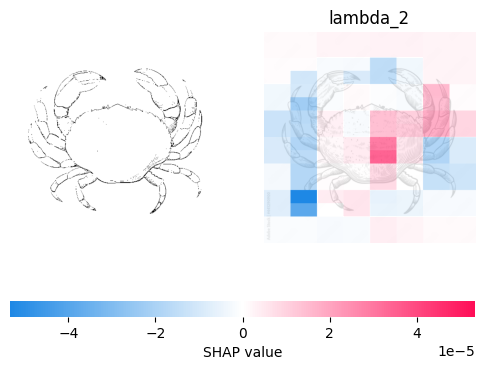

In [15]:
########################################## S H A P -- V I S U A L I Z A T I O N ##########################################

!pip install shap --upgrade shap
!pip install opencv-python --upgrade
!pip install tqdm --upgrade tqdm

import cv2

import shap
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

model_path = 'C:\\Users\\leest\\model.h5'  
original_model = load_model(model_path)

model_shap = tf.keras.models.clone_model(original_model)

model_shap.set_weights([w.astype('float32') for w in original_model.get_weights()])

#img_path = 'D:\\Deep Learning Project\\final\\CXRNormalClassifer\\correctLabelDataVersion\\final\\train\\trainset3\\non_COVID (636).png'
#img_path = 'D:\\Deep Learning Project\\final\\CXRNormalClassifer\\correctLabelDataVersion\\final\\train\\trainset3\\covid_1752.png'
img_path = 'C:\\Users\\leest\\OneDrive\\Desktop\\1000_F_441290900_JdXNtu6vcPtYOenFo4Y466GbqdyczOxR.jpg'

img = Image.open(img_path).convert('RGB').resize(TARGET_SIZE) 
img_array = np.array(img)
img_array = np.expand_dims(img_array, axis=0)  
img_array = img_array.astype(np.float32)

import tensorflow as tf
output = tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.float32))(original_model.output)
new_model = tf.keras.models.Model(inputs=original_model.input, outputs=output)
print(img_array.shape)
masker = shap.maskers.Image("inpaint_telea", (512, 512, 3))  
explainer = shap.Explainer(new_model, masker)  

shap_values = explainer(img_array)

shap.image_plot(shap_values, img_array)